# Exploratory data analaysis for world bank data

## Set export to True if you wish to export graphs and tables


In [1]:
export = True
seed = 1337


In [2]:
import warnings
from sklearn.cluster import KMeans
from matplotlib.cm import get_cmap
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from auxiliary_code.helper_functions import *
from auxiliary_code.Clustering import Clustering
import matplotlib.dates as mdate
from sklearn.metrics import confusion_matrix


warnings.simplefilter('ignore')
%matplotlib inline


In [3]:
df_phase_fews_net = pd.read_csv(
    '../datasets/fews_net_ipc.csv', parse_dates=['date'])
set_index(df_phase_fews_net)

df_ipc = pd.read_csv('../datasets/ipc_processed.csv',
                     parse_dates=['date'], usecols=['date', 'area', 'area_phase'])
set_index(df_ipc)

df_food_crisis = pd.read_csv(
    '../datasets/world_bank_processed.csv', parse_dates=['date'])
set_index(df_food_crisis)

df_shape = get_shape_file('../geography/Somalia/Som_Admbnda_Adm2_UNDP.shp')

In [4]:
df_sum = df_food_crisis.describe().transpose().iloc[:, 1:].round(3)

if export:
    with open('../tables/world_bank_summary.tex', 'w') as file:
        file.write(df_sum.style.to_latex())

df_sum


,mean,std,min,25%,50%,75%,max
admin_code,36.500,21.361,0.000,18.000,36.500,55.000,73.000
centx,45.421,2.498,41.429,43.433,45.333,47.222,50.794
centy,5.591,3.529,-0.854,2.679,4.699,9.230,11.668
fews_ipc,2.309,0.786,1.000,2.000,2.000,3.000,5.000
fews_ha,0.207,0.405,0.000,0.000,0.000,0.000,1.000
fews_proj_near,2.328,0.806,1.000,2.000,2.000,3.000,5.000
fews_proj_near_ha,0.071,0.256,0.000,0.000,0.000,0.000,1.000
fews_proj_med,2.269,0.791,1.000,2.000,2.000,3.000,5.000
fews_proj_med_ha,0.034,0.181,0.000,0.000,0.000,0.000,1.000
ndvi_mean,0.252,0.119,0.084,0.162,0.214,0.313,0.719


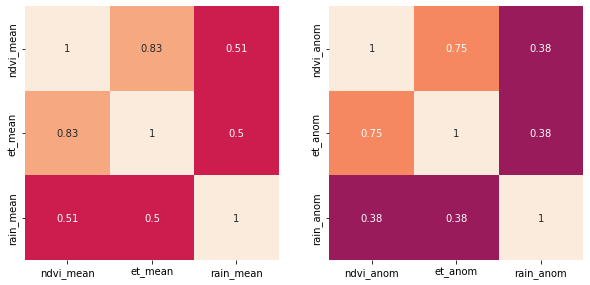

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 7))


sns.heatmap(df_food_crisis[['ndvi_mean', 'et_mean', 'rain_mean']].corr(
), vmin=0, vmax=1, annot=True, ax=ax[0], cbar=False)
sns.heatmap(df_food_crisis[['ndvi_anom', 'et_anom', 'rain_anom']].corr(
), vmin=0, vmax=1, annot=True, ax=ax[1], cbar=False)

ax[0].set_aspect('equal', adjustable='box')
ax[1].set_aspect('equal', adjustable='box')

if export:
    plt.savefig('../figures/corr_climate.pdf',
                format='pdf', bbox_inches='tight')


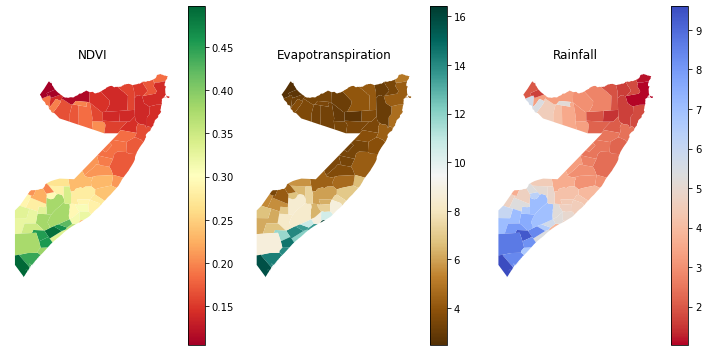

In [6]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 5))

df_mean_rain_area = df_food_crisis.groupby(
    'area')[['ndvi_mean', 'et_mean', 'rain_mean']].mean()
df_plot_phase = df_shape.merge(
    df_mean_rain_area, left_index=True, right_index=True)
df_plot_phase.plot(column='ndvi_mean', cmap='RdYlGn', legend=True, ax=axs[0])
df_plot_phase.plot(column='et_mean', cmap='BrBG', legend=True, ax=axs[1])
df_plot_phase.plot(column='rain_mean', cmap='coolwarm_r',
                   legend=True, ax=axs[2])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

axs[0].set_title('NDVI')
axs[1].set_title('Evapotranspiration')
axs[2].set_title('Rainfall')


plt.tight_layout()

if export:
    plt.savefig('../figures/climate_mean_area.pdf',
                format='pdf', bbox_inches='tight')


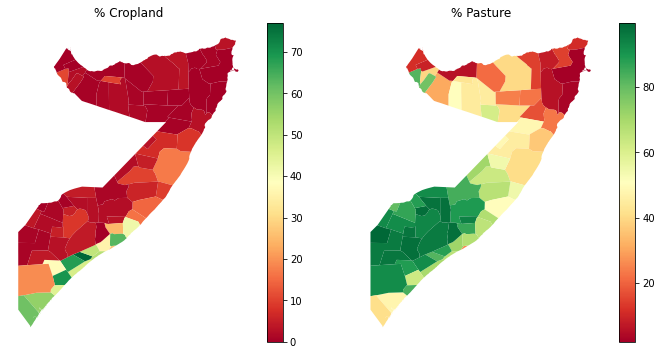

In [29]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

df_mean_rain_area = df_food_crisis.groupby(
    'area')[['cropland_pct', 'pasture_pct', 'ruggedness_mean']].mean()
df_plot_phase = df_shape.merge(
    df_mean_rain_area, left_index=True, right_index=True)
df_plot_phase.plot(column='cropland_pct', cmap='RdYlGn',
                   legend=True, ax=axs[0])
df_plot_phase.plot(column='pasture_pct', cmap='RdYlGn', legend=True, ax=axs[1])

axs[0].axis('off')
axs[1].axis('off')

axs[0].set_title('% Cropland')
axs[1].set_title('% Pasture')


plt.tight_layout()

if export:
    plt.savefig('../figures/agriculture_mean_area.pdf',
                format='pdf', bbox_inches='tight')


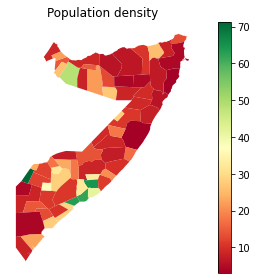

In [8]:
fig, ax = plt.subplots()
df_food_crisis['density'] = df_food_crisis['pop'] / \
    df_food_crisis['surface_area']
df_mean_rain_area = df_food_crisis.groupby('area')[['density']].mean()
mask = df_mean_rain_area < df_mean_rain_area.quantile(.95)

df_plot_phase = df_shape.merge(
    df_mean_rain_area[mask], left_index=True, right_index=True)
df_plot_phase.plot(column='density', cmap='RdYlGn', legend=True, ax=ax)


ax.axis('off')

ax.set_title('Population density')


plt.tight_layout()

if export:
    plt.savefig('../figures/average_density.pdf',
                format='pdf', bbox_inches='tight')


In [9]:
df_food_crisis.sort_index(inplace=True)

dates = sorted(get_date(df_food_crisis).unique())
n_dates = len(dates)
areas = get_area(df_food_crisis).unique()
n_areas = len(areas)

values_per_area = []
df_food_crisis['normalized_acled'] = df_food_crisis['acled_count'] / \
    df_food_crisis['pop']
df_food_crisis['normalized_fatalities'] = df_food_crisis['acled_count'] / \
    df_food_crisis['pop']
colnames = ['ndvi_mean', 'et_mean', 'rain_mean',
            'p_staple_food', 'normalized_acled', 'normalized_fatalities']

values_per_area = np.zeros([n_areas, n_dates, len(colnames)])
for i, [_, df] in enumerate(df_food_crisis.groupby('area')):
    values_per_area[i] = df[colnames].to_numpy()


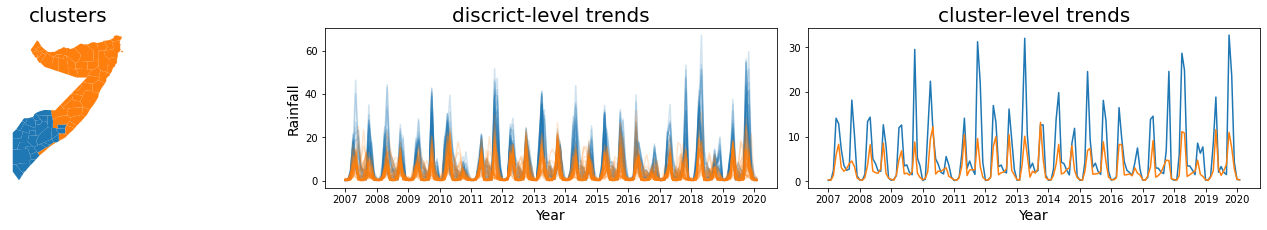

In [11]:
df_unstacked = df_food_crisis['rain_mean'].unstack()
mask = df_unstacked.isna().sum(axis=1) == 0
df_unstacked = df_unstacked[mask]
dates = df_unstacked.columns.get_level_values(0)
areas = df_unstacked.index
values = df_unstacked.to_numpy()

clustering = Clustering([2], seed)
fig = clustering.spatial_clustering(areas, values, dates, df_shape, xlab='Year', ylab='Rainfall')
plt.tight_layout()

if export:
    fig.savefig('../figures/rainfall_clusters.pdf', format='pdf')

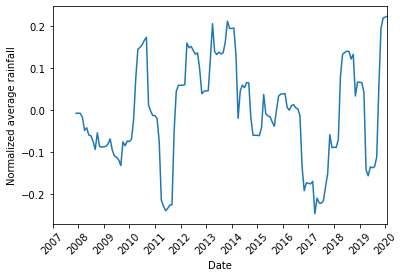

In [12]:
fig, ax = plt.subplots()

norm_rain = df_food_crisis['rain_mean'].copy()
norm_rain = norm_rain.groupby('area').apply(lambda x: (x - x.mean())/x.std())
norm_rain = norm_rain.groupby('date').mean()
norm_rain.rolling(12).mean().plot()
ax.set_xticks(range(444, 612, 12))
ax.set_xticklabels(range(2007, 2021))
ax.set_xlabel('Date')
ax.set_ylabel('Normalized average rainfall')
plt.xticks(rotation=45);

if export:
    fig.savefig('../figures/normalized_total_rainfall_12.pdf', format='pdf')

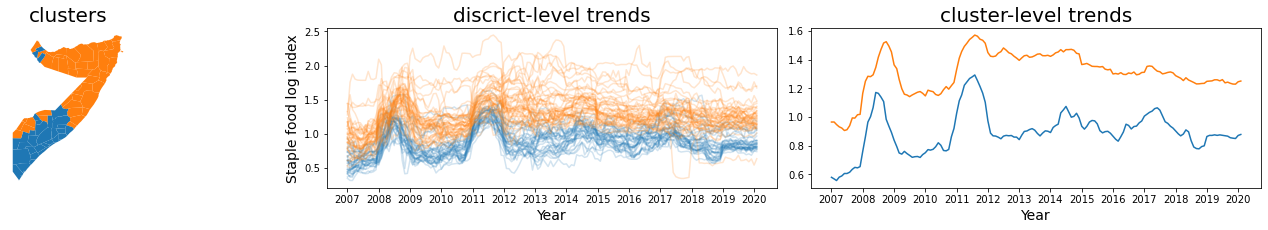

In [27]:
df_unstacked = df_food_crisis['p_staple_food'].unstack()
mask = df_unstacked.isna().sum(axis=1) == 0
df_unstacked = df_unstacked[mask]
dates = df_unstacked.columns.get_level_values(0)
areas = df_unstacked.index
values = df_unstacked.to_numpy()

clustering = Clustering([2], seed)
fig = clustering.spatial_clustering(areas, values, dates, df_shape, xlab='Year', ylab='Staple food log index')
plt.tight_layout()

if export:
    fig.savefig('../figures/staple_index_clusters.pdf', format='pdf')

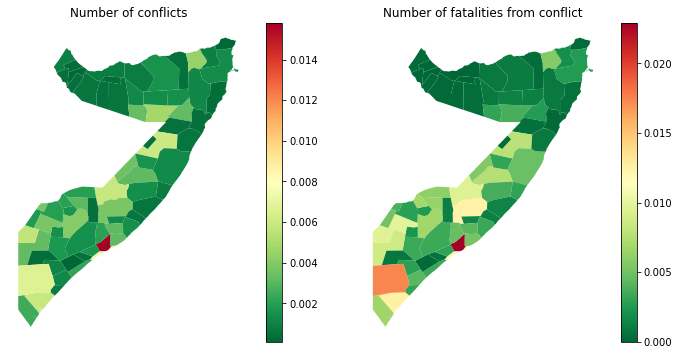

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

df_mean_acled_area = df_food_crisis[['acled_count', 'acled_fatalities']].copy()
df_mean_acled_area = df_mean_acled_area.div(df_food_crisis['pop'], axis=0)
df_mean_acled_area = df_mean_acled_area.groupby(
    'area')[['acled_count', 'acled_fatalities']].sum()
df_plot_phase = df_shape.join(df_mean_acled_area)

df_plot_phase.plot(column='acled_count', cmap='RdYlGn_r', legend=True, ax=axs[0])
df_plot_phase.plot(column='acled_fatalities', cmap='RdYlGn_r', legend=True, ax=axs[1])

axs[0].axis('off')
axs[1].axis('off')

axs[0].set_title('Number of conflicts')
axs[1].set_title('Number of fatalities from conflict')


plt.tight_layout()

if export:
    plt.savefig('../figures/acled_mean_area.pdf',
                format='pdf', bbox_inches='tight')

In [157]:
df_food_crisis['normalized_acled'] = df_food_crisis['acled_count'] / \
    df_food_crisis['pop']
df_food_crisis['normalized_fatalities'] = df_food_crisis['acled_fatalities'] / \
    df_food_crisis['pop']

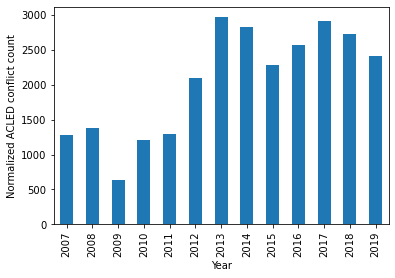

In [167]:
fig, ax = plt.subplots()

((df_food_crisis.groupby('year')['acled_count'].sum())[:-1].plot(kind='bar')).plot(kind='bar', ax=ax)

ax.set_xlabel('Year')
ax.set_ylabel('Normalized ACLED conflict count')


if export:
    plt.savefig('../figures/acled_yearly.pdf',
                format='pdf')

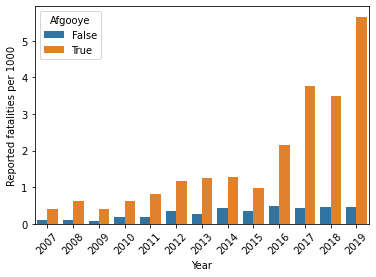

In [168]:
fig, ax = plt.subplots()

df1 = df_food_crisis.groupby('year')[['normalized_fatalities']].mean()[:-1]*12*1000
df1 = pd.concat([df1, df_food_crisis.loc['afgooye'].groupby('year')['normalized_fatalities'].sum()[:-1]*1000])
df1['acled_fatalities'] = df1.sum(axis=1)
df1['Afgooye'] = [False] * (len(df1)//2) + [True] * (len(df1)//2)
df1 = df1.reset_index()
sns.barplot(x='year', y='acled_fatalities', hue='Afgooye', data=df1, ax=ax)
plt.setp(ax.lines, zorder=0)
plt.setp(ax.collections, zorder=100)
ax.set_ylabel('Reported fatalities per 1000')
ax.set_xlabel('Year')
plt.xticks(rotation=45);

if export:
    plt.savefig('../figures/acled_yearly_afgooye.pdf',
                format='pdf')

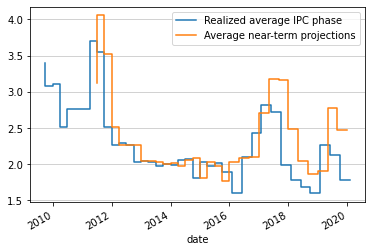

In [196]:
fig, ax = plt.subplots()

df_food_crisis['fews_ipc'].dropna().groupby('date').mean().plot(drawstyle='steps-pre')
df_food_crisis['fews_proj_near'].groupby('area').shift(3).dropna().groupby('date').mean().plot(drawstyle='steps-pre')

ax.grid(axis='y', alpha=0.7)
ax.legend(['Realized average IPC phase', 'Average near-term projections'])

fig.savefig('../figures/average_near_proj_time.pdf', format='pdf')

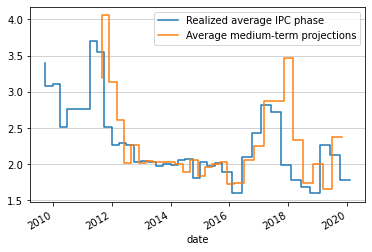

In [197]:
fig, ax = plt.subplots()

df_food_crisis['fews_ipc'].dropna().groupby('date').mean().plot(drawstyle='steps-pre')
df_food_crisis['fews_proj_med'].groupby('area').shift(5).dropna().groupby('date').mean().plot(drawstyle='steps-pre')

ax.grid(axis='y', alpha=0.7)
ax.legend(['Realized average IPC phase', 'Average medium-term projections'])

fig.savefig('../figures/average_med_proj_time.pdf', format='pdf')

0.32207207207207206
0.3000931966449208


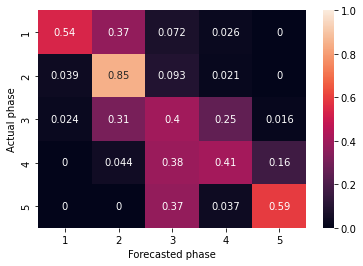

In [188]:
fig, ax = plt.subplots()

true = df_food_crisis[['fews_ipc']].dropna().copy()
pred = df_food_crisis['fews_proj_med'].dropna().groupby('area').shift(1).copy()
pred_df = true.join(pred).dropna()

sns.heatmap(confusion_matrix(pred_df['fews_ipc'], pred_df['fews_proj_med'], normalize='true'), annot=True, vmin=0, vmax=1, ax=ax)
ax.set_xticklabels(range(1, 6))
ax.set_yticklabels(range(1, 6))
ax.set_xlabel('Forecasted phase')
ax.set_ylabel('Actual phase')

print(abs(pred_df['fews_ipc'] - pred_df['fews_proj_med']).mean())
print(abs(pred_df['fews_ipc'] - pred_df['fews_ipc'].groupby('area').shift(1)).mean())

fig.savefig('../figures/fews_proj_medium_1_conf.pdf', format='pdf')

0.45619757688723206
0.41041041041041043


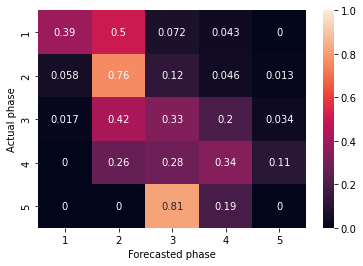

In [189]:
fig, ax = plt.subplots()

true = df_food_crisis[['fews_ipc']].dropna().copy()
pred = df_food_crisis['fews_proj_med'].dropna().groupby('area').shift(2).copy()
pred_df = true.join(pred).dropna()

sns.heatmap(confusion_matrix(pred_df['fews_ipc'], pred_df['fews_proj_med'], normalize='true'), annot=True, vmin=0, vmax=1, ax=ax)
ax.set_xticklabels(range(1, 6))
ax.set_yticklabels(range(1, 6))
ax.set_xlabel('Forecasted phase')
ax.set_ylabel('Actual phase')

print(abs(pred_df['fews_ipc'] - pred_df['fews_proj_med']).mean())
print(abs(pred_df['fews_ipc'] - pred_df['fews_ipc'].groupby('area').shift(2)).mean())

fig.savefig('../figures/fews_proj_medium_2_conf.pdf', format='pdf')

0.33609415867480386
0.29009009009009007


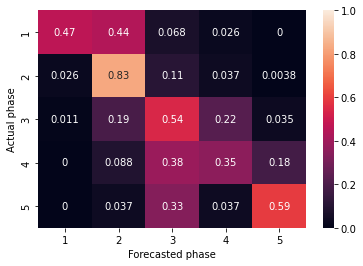

In [190]:
fig, ax = plt.subplots()

true = df_food_crisis[['fews_ipc']].dropna().copy()
pred = df_food_crisis['fews_proj_near'].dropna().groupby('area').shift(1).copy()
pred_df = true.join(pred).dropna()

sns.heatmap(confusion_matrix(pred_df['fews_ipc'], pred_df['fews_proj_near'], normalize='true'), annot=True, vmin=0, vmax=1, ax=ax)
ax.set_xticklabels(range(1, 6))
ax.set_yticklabels(range(1, 6))
ax.set_xlabel('Forecasted phase')
ax.set_ylabel('Actual phase')

print(abs(pred_df['fews_ipc'] - pred_df['fews_proj_near']).mean())
print(abs(pred_df['fews_ipc'] - pred_df['fews_ipc'].groupby('area').shift(1)).mean())

fig.savefig('../figures/fews_proj_near_1_conf.pdf', format='pdf')